In [1]:
import sympy
import numpy
import suncal
sympy.init_printing()

# Function Options

## Strings

String expressions can be entered, with basic functions (sin, cos, exp, log, etc.) recognized. The string must by "sympifyable". Note: powers can be entered using python syntax of `x**2` or carat syntax `x^2`.

In [2]:
# String
fstr = 'sqrt(a**2 + b**2)'

inputs = [{'name':'a', 'nom':24, 'uncerts':[{'std':.5}]},
          {'name':'b', 'nom':32, 'uncerts':[{'std':.5}]}]
u = suncal.UncertCalc(fstr, inputs=inputs)
u.calculate()




Method            |Mean  |Standard Uncertainty 
------------------|------|---------------------
GUM Approximation |40.00 |0.50                 
Monte Carlo       |40.00 |0.50                 



In [3]:
# String gets converted to sympy object internally.
u.functions[0].function

## Sympy Objects
A sympy expression can also be used as the input function. This allows more algebraic manipulation before using in the calculator.

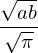

In [4]:
a, b = sympy.symbols('a, b')
fsym = sympy.sqrt(a * b / sympy.pi)
fsym

In [5]:
u = suncal.UncertCalc(fsym, inputs=inputs)
u.calculate()




Method            |Mean  |Standard Uncertainty 
------------------|------|---------------------
GUM Approximation |15.64 |0.20                 
Monte Carlo       |15.63 |0.20                 



## Python callables
Callable python functions may also be used. Function arguments must match input names defined in the calculator. 

In [6]:
def myfunc(a, b):
    return a * b + 10

u = suncal.UncertCalc(myfunc, inputs=inputs)
u.calculate()




Method            |Mean |Standard Uncertainty 
------------------|-----|---------------------
GUM Approximation |778  |20                   
Monte Carlo       |778  |20                   



### Callable with kwargs
Callables can also take variable keyword arguments (`**kwargs`) if the kwnames parameter is specified. The function must be added using set_function(). Be careful when using units, as the conversions may not happen automatically inside the function.

In [7]:
def myfunc2(**kwargs):
    X = numpy.array(list(kwargs.values()))
    return X.sum() / len(X)

data = {'X1':2, 'X2':4, 'X3':6, 'X4':8}

u = suncal.UncertCalc(samples=1000)
u.set_function(myfunc2, kwnames=data.keys())  # Must specify names of keyword arguments
for i, xval in enumerate([2, 4, 6, 8]):
    u.set_input('X{}'.format(i+1), nom=xval)
    u.set_uncert('X{}'.format(i+1), std=.2)
    
u.calculate()

/Users/cjdelke/miniconda3/envs/uncertosx/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)





Method            |Mean |Standard Uncertainty 
------------------|-----|---------------------
GUM Approximation |5.00 |0.10                 
Monte Carlo       |5.00 |0.10                 



### More notes on python callable functions

- Monte Carlo calculation will be much faster if the callable function is vectorizable. If not, the calculator will resort to calling the function N times. (Note the reduced samples in the example above.)
- The gradients used in the GUM calculation will be solved numerically. Thus the derivation report will not be available for callable functions.